In [1]:
#Importamos las librerías a usar
import warnings
import pandas as pd
from datetime import datetime
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten
from sklearn.preprocessing import MinMaxScaler
import keras
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#Cargamos los conjuntos de datos

Boya3_30 = pd.read_csv('../Fase_2/Paso 4/Boya3_30_conduc_train.csv', sep=",", decimal=".")
Boya3_30['Date'] = pd.to_datetime(Boya3_30['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya3_30_train = Boya3_30[0:56]
Boya3_45 = pd.read_csv('../Fase_2/Paso 4/Boya3_45_conduc_test.csv', sep=",", decimal=".")
Boya3_45['Date'] = pd.to_datetime(Boya3_45['Date'],format="%d/%m/%Y").astype(np.int64) // 10 ** 9
Boya3_45_test = Boya3_45[0:20]

In [3]:
EPOCHS = 40
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(1, input_shape=(1,),activation='tanh'))
    #model.add(Flatten()) No se puede usar porque solo hay un input
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mean_squared_error"])
    model.summary()
    return model

In [4]:
from sklearn.externals import joblib

#Segundo escenario
scaler = MinMaxScaler(feature_range=(-1, 1))
train = Boya3_30_train.values
test = Boya3_45_test.values
full = np.append(train,test,axis=0)
full = full.astype(np.float64)
full[:,1] = scaler.fit_transform(full[:,1].reshape(-1,1)).reshape(1,-1)
train = full[0:56]
test = full[56:76]

joblib.dump(scaler, "escala_escenario_2.scale") 
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]


In [5]:
model = crear_modeloFF()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=7)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________

Train on 56 samples, validate on 20 samples
Epoch 1/40
56/56 [==============================] - 0s 4ms/step - loss: 0.9058 - mean_squared_error: 1.0080 - val_loss: 0.5888 - val_mean_squared_error: 0.3787
Epoch 2/40
56/56 [==============================] - 0s 410us/step - loss: 0.9037 - mean_squared_error: 1.0040 - val_loss: 0.5865 - val_mean_squared_error: 0.3760
Epoch 3/40
56/56 [==============================] - 0s 463us/step - loss: 0.9013 - mean_squared_error: 0.9998 - val_loss: 0.5841 - val_mean_squared_error: 

Text(0.5, 1.0, 'validate')

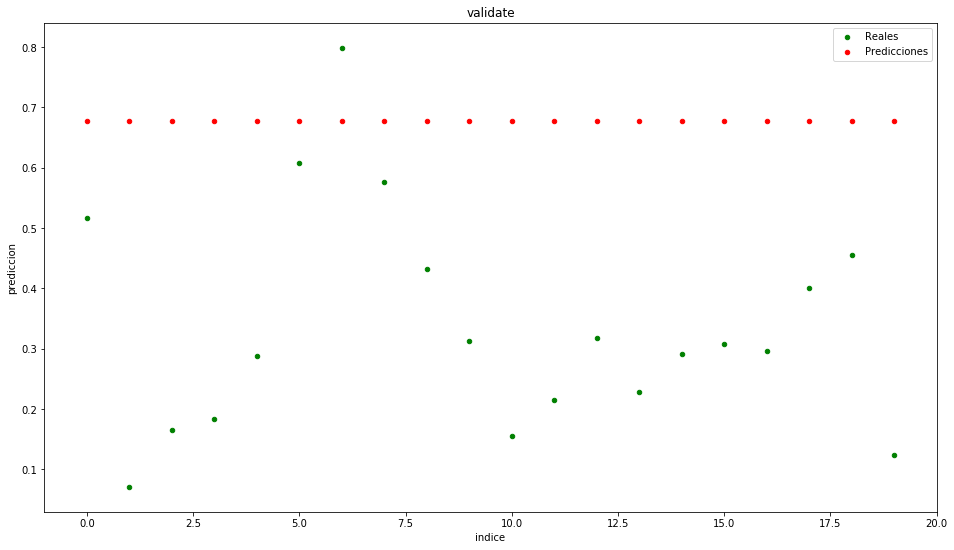

In [6]:
results=model.predict(x_val)
def sacarResultados(results):
    return [x[0] for x in results]
resultados = sacarResultados(results)
validacion = pd.DataFrame({"reales":y_val,"prediccion":resultados})
validacion['indice'] = range(0,20)
#validacion.plot.scatter(x="indice)
ax1 = validacion.plot(kind="scatter",x="indice",y="reales", color="g",label="Reales")
validacion.plot(kind="scatter",x="indice",y="prediccion", ax=ax1, color="r",label="Predicciones")
plt.title('validate')

Text(0.5, 1.0, 'Validate loss')

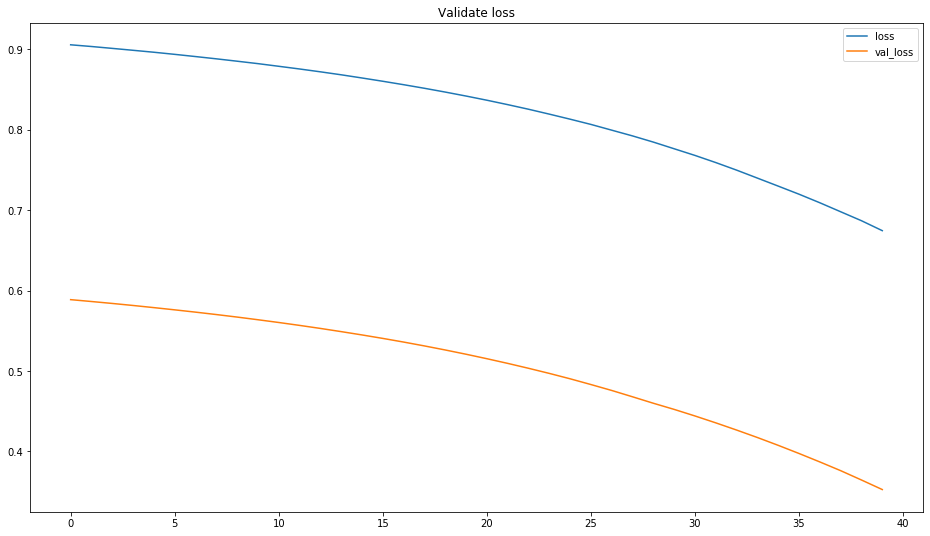

In [7]:
validate_loss = pd.DataFrame({"loss":history.history['loss'],"val_loss":history.history['val_loss']})
validate_loss.plot()
plt.title("Validate loss")

In [8]:
compara = pd.DataFrame(np.array([y_val, [x[0] for x in results]])).transpose()
compara.columns = ['real', 'prediccion']

inverted = scaler.inverse_transform(compara.values)

compara2 = pd.DataFrame(inverted)
compara2.columns = ['real', 'prediccion']
compara2['diferencia'] = abs(compara2['real'] - compara2['prediccion'])
compara2.head()

,real,prediccion,diferencia
0,0.078792,0.082663,0.003872
1,0.068083,0.082663,0.014580
2,0.070333,0.082663,0.012330
3,0.070792,0.082663,0.011872
4,0.073292,0.082663,0.009372


In [9]:
compara2.describe()

,real,prediccion,diferencia
count,20.000000,2.000000e+01,20.000000
mean,0.074479,8.266338e-02,0.008476
std,0.004413,1.423831e-17,0.003789
min,0.068083,8.266338e-02,0.001663
25%,0.071354,8.266338e-02,0.005768
50%,0.073646,8.266338e-02,0.009018
75%,0.076896,8.266338e-02,0.011309
max,0.085583,8.266338e-02,0.014580


Text(0.5, 1.0, 'Comparación predicciones')

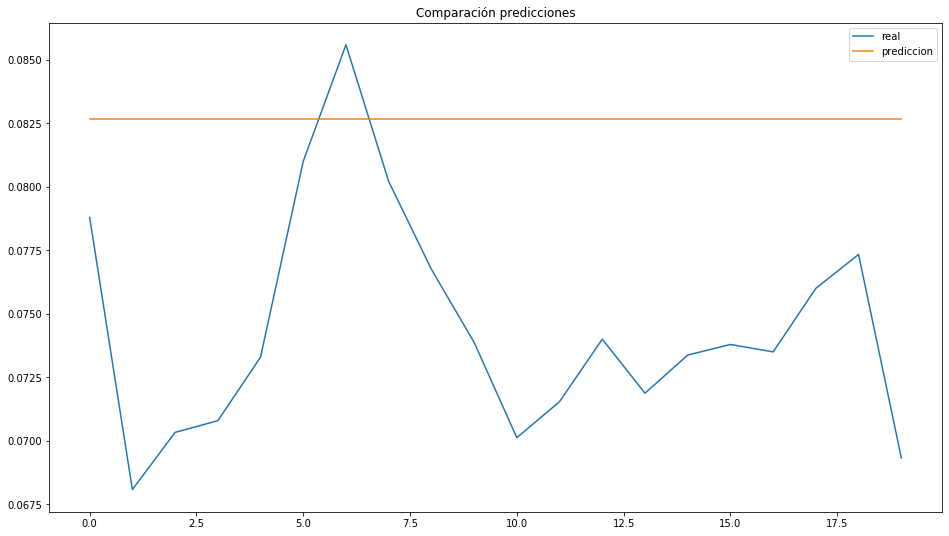

In [10]:
comparacion_predicciones = pd.DataFrame({"real":compara2['real'],"prediccion":compara2['prediccion']})
comparacion_predicciones.plot()
plt.title("Comparación predicciones")

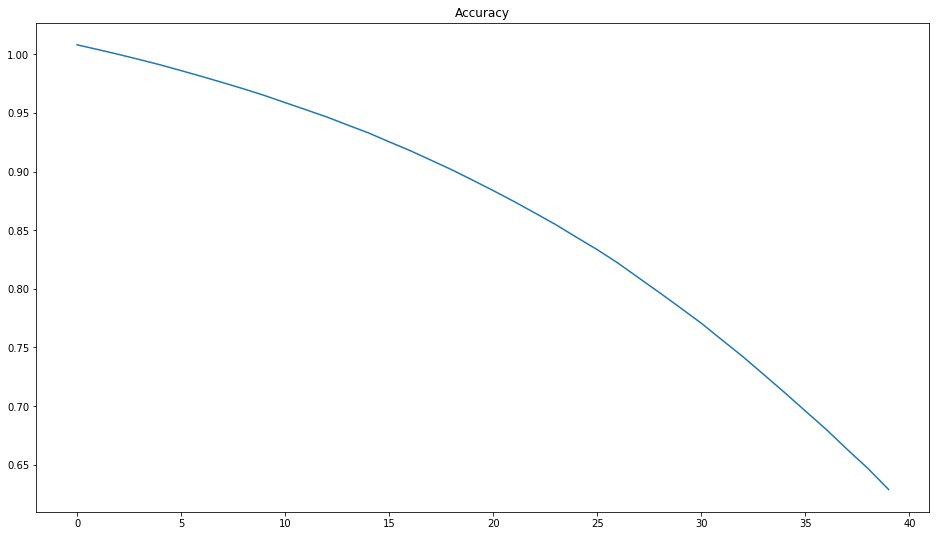

In [11]:
plt.title('Accuracy')
plt.plot(history.history['mean_squared_error'])
plt.show()

In [12]:
model.save('escenario_2.h5')